In [56]:
import pandas as pd
import numpy as np
import datetime

import collections
from itertools import chain

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

# Классы и функции

### Создание фичей по заказам и их агрегация

In [57]:
class ComponentReducer:
    
    def __init__(self):
        from collections import defaultdict
        self.last_customer_id = None
        self.last_order_id = None
        self.prev_ts = None
        self.possible_keys = defaultdict(list)
        self.arr_revenue = []
        self.arr_squares = []
        self.arr_deltas = []
        self.arr_of_arr_dishes = []
        self.cnt = 0
        self.items = dict()

    def print_result(self):
        final_features = [self.last_customer_id, self.last_order_id]

        for k in range(4, 1, -1):
            final_features.append(np.mean(self.arr_revenue[-k:]))
        
        try:
            final_features.append(self.arr_revenue[-1] / self.arr_revenue[-2])
        except:
            final_features.append(-1)
            
        for k in range(4, 1, -1):
            final_features.append(np.mean(self.arr_squares[-k:]))

        for key in ['drinks', 'burgers', 'snack', 'offer', 'chicken', 'bucket', 'count']:
            els = self.possible_keys[key]
            for k in range(4, 1, -1):
                final_features.append(np.mean(els[-k:]))
            try:
                final_features.append(els[-1] / els[-2])
            except:
                final_features.append(-1)
            
        final_features.append(np.mean(self.arr_deltas[-3:]))
        final_features.append(self.arr_deltas[-1])
        
        arr_1d_dishes = list(chain(*self.arr_of_arr_dishes))
        arr_1d_weekday = list(chain(*[self.arr_of_arr_weekdays]))
        mc = collections.Counter(arr_1d_dishes)
        mc_weekdays = collections.Counter(arr_1d_weekday)
        for i in range(2):
            try:
                final_features.append(mc.most_common()[i][0])
                final_features.append(mc_weekdays.most_common()[i][0])
            except:
                final_features.append(None)

        final_features.append(len(set(arr_1d_dishes)))
        
        
        hour = self.items['start_ts'].hour
        
        final_features.append(hour)
        
        if (hour >= 6) and (hour < 12):
            final_features.append('morning')
        elif (hour >= 12) and (hour < 17):
            final_features.append('morning')
        elif (hour >= 17) and (hour < 22):
            final_features.append('evening')
        else:
            final_features.append('night')
        
        weekday = self.items['start_ts'].weekday() + 1
        
        final_features.append(weekday)
        
        if weekday <= 5:
            final_features.append('workday')
        else:
            final_features.append('weekend')
                
        for col in ['revenue', 'square', 'drinks', 'burgers', 'snack', 'offer', 'chicken', 'bucket']:
            final_features.append(self.items[col])
            
        final_features.append(self.cnt)

        return final_features

    def reset(self):
        self.last_customer_id = None
        self.last_order_id = None
        self.prev_ts = None
        self.possible_keys.clear()
        self.arr_revenue = []
        self.arr_squares = []
        self.arr_deltas = []
        self.arr_of_arr_dishes = []
        self.arr_of_arr_weekdays = []
        self.cnt = 0
        self.items = dict()


    def get_item_dict(self, items):

        d = {
            'customer_id': items.loc['customer_id'],
            'start_ts': items.loc['startdatetime'],
            'revenue': items.loc['revenue'],
            'square': items.loc['ownareaall_sqm'],
            'drinks': items.loc['drinks'],
            'burgers': items.loc['burgers'],
            'snack': items.loc['snack'],
            'offer': items.loc['offer'],
            'chicken': items.loc['chicken'],
            'bucket': items.loc['bucket'],
            'count': items.loc['count'],
            'order_id': items.loc['order_id'],
            'dish_arr': items.loc['dish_name']
        }
        return d

    def push_line(self, line):
        from copy import deepcopy

        res = None
        items = self.get_item_dict(line)


        order_id = items['order_id']
        customer_id = items['customer_id']
        unix_ts = items['start_ts']
        
        self.items = items

        if self.last_customer_id is not None and self.last_customer_id != customer_id:
            res = self.print_result()
            self.reset()

        if self.last_order_id is not None and self.last_order_id != order_id:
            res = self.print_result()

        self.arr_revenue.append(float(items['revenue']))
        self.arr_squares.append(float(items['square']))
        
        for key in ['drinks', 'burgers', 'snack', 'offer', 'chicken', 'bucket', 'count']:
            self.possible_keys[key].append(items[key])
            
        if self.prev_ts is not None:
            self.arr_deltas.append((self.prev_ts - unix_ts).total_seconds())
        else:
            self.arr_deltas.append(-1)
        
        self.arr_of_arr_dishes.append(items['dish_arr'])
        self.arr_of_arr_weekdays.append(items['start_ts'].weekday())

        self.cnt += 1

        self.last_customer_id = customer_id
        self.last_order_id = order_id
        self.prev_ts = unix_ts
        
        return res

### Извлечение фичей из названий продуктов

In [58]:
def make_features(df: pd.DataFrame, flg_train=True) -> pd.DataFrame:

    if flg_train:
        df_orders = df.drop_duplicates(subset=['customer_id', 'startdatetime']).sort_values(by=['customer_id', 'startdatetime']).reset_index(drop=True)
        df_orders['next_startdatetime'] = df_orders.groupby(['customer_id'])['startdatetime'].shift(-1)
        df_orders['days_delta'] = (df_orders['next_startdatetime'] - df_orders['startdatetime']).apply(lambda row: row.total_seconds() // (24*60*60))
        df_orders['trg_days'] = df_orders.apply(lambda row: row.days_delta if str(row.days_delta) != 'nan' else row.date_diff_post, axis=1)
        df_orders['trg_flg'] = df_orders['trg_days'].apply(lambda row: 1 if row <= 60 else 0)
        df_orders[['customer_id', 'startdatetime', 'trg_days', 'trg_flg']].to_pickle('new_trg.pkl')

    df['drinks'] = df.dish_name.str.lower().str.contains(r'0[,.]|кофе|латте|американо|капучино|липтон|шейк|балтика|туборг|какао|кола|лимонад|чай|сок|адреналин|миринда|эвервесс|байкал|дюшес|мандарин|севен')
    df['burgers'] = df.dish_name.str.lower().str.contains(r'воппер|ангус|гранд|чизбургер|гамбургер')
    df['snack'] = df.dish_name.str.lower().str.contains(r'шт|фри')
    df['1rub'] = df.dish_name.str.lower().str.contains(r'1rub')
    df['chicken'] = df.dish_name.str.lower().str.contains(r'куриц|чикен')
    df['bucket'] = df.dish_name.str.lower().str.contains(r'букет')
    df['dessert'] = df.dish_name.str.lower().str.contains(r'пирожок|рожок|маффин')
    df['pivo'] = df.dish_name.str.lower().str.contains(r'туборг|балтика|пиво')
    df['sok'] = df.dish_name.str.lower().str.contains(r'сок|а4')
    df['toilet'] = df.format_name.str.lower().str.contains(r'без туалета')
    df['foodcourt'] = df.format_name.str.lower().str.contains(r'фудкорт')
    df['otdelno'] = df.format_name.str.lower().str.contains(r'отдельно стоящий')
    df['count'] = 1
    df['offer'] = df.revenue.apply(lambda x: True if x <= 19.98 else False)
    df['offer'] = df['1rub'] + df['offer']
    df = df.drop(columns=['1rub'])

    return df

# Работа с данными

In [59]:
df = pd.read_parquet("train.parquet")
# df = pd.read_parquet('train_dataset_hackaton2023_train.parquet')

df = make_features(pd.concat([df.head(1000), df.tail(1000)]))

### Группировка по заказам

In [60]:
df_check = df[
    ['customer_id', 'revenue', 'startdatetime', 'ownareaall_sqm', 'drinks',
     'burgers', 'snack', 'offer', 'chicken', 'bucket', 'dessert', 'pivo', 
     'sok', 'toilet', 'foodcourt', 'otdelno', 'count', 'dish_name']
].groupby(['customer_id', 'startdatetime']) \
    .agg({
    'revenue': 'sum',
    'ownareaall_sqm':'mean',
    'drinks':'sum',
    'burgers':'sum',
    'snack':'sum',
    'offer':'sum',
    'chicken':'sum',
    'bucket':'sum',
    'dessert':'sum',
    'pivo':'sum',
    'sok':'sum',
    'toilet':'max',
    'foodcourt':'max',
    'otdelno':'max',
    'count':'sum',
    'dish_name': list
}).reset_index()

In [61]:
df_sample = df_check.sort_values(by=['customer_id', 'startdatetime']).reset_index()
df_sample['order_id'] = df_sample['customer_id'].astype(str) + '_' + df_sample['startdatetime'].astype(str)

In [62]:
df_sample.shape

(634, 20)

In [ ]:
# df_sample.to_pickle('feats.pkl')

## Reducer

In [ ]:
# df_sample = pd.read_pickle('feats.pkl')

### Создание обучающей выборки

In [63]:
reducer = ComponentReducer()
reducer.reset()

out_arr = []
cols = ['customer_id', 'startdatetime', 'revenue', 'ownareaall_sqm', 'drinks',
        'burgers', 'snack', 'offer', 'chicken', 'bucket', 'count', 'order_id', 'dish_name']

for index, row in tqdm(df_sample[cols].iterrows()):
    res = reducer.push_line(row)
    if res is not None:
        out_arr.append(res)

res = reducer.print_result()
if res is not None:
    out_arr.append(res)

634it [00:00, 1557.78it/s]


In [64]:
df_train_new = pd.DataFrame(out_arr, columns=[
    'customer_id', 'order_id',
    'mean_revenue_last4', 'mean_revenue_last3', 'mean_revenue_last2', 'rat_revenue',
    'mean_squares_last4', 'mean_squares_last3', 'mean_squares_last2',
    'mean_drinks_last4', 'mean_drinks_last3', 'mean_drinks_last2', 'rat_drinks',
    'mean_burgers_last4', 'mean_burgers_last3', 'mean_burgers_last2', 'rat_burgers',
    'mean_snack_last4', 'mean_snack_last3', 'mean_snack_last2', 'rat_snack',
    'mean_offer_last4', 'mean_offer_last3', 'mean_offer_last2', 'rat_offer',
    'mean_chicken_last4', 'mean_chicken_last3', 'mean_chicken_last2', 'rat_chicken',
    'mean_bucket_last4', 'mean_bucket_last3', 'mean_bucket_last2', 'rat_bucket',
    'mean_count_last4', 'mean_count_last3', 'mean_count_last2', 'rat_count',
    'gap_last3', 'last_gap',
    'mc1_dish', 'mc1_weekday', 'mc2_dish', 'mc2_weekday',
    'nunique_dishes', 'cat_hour', 'cat_gr_hour', 'cat_weekday', 'cat_gr_weekday',
    'revenue_curr', 'square_curr', 'drinks_curr', 'burgers_curr', 'snack_curr', 'offer_curr', 
    'chicken_curr', 'bucket_curr',     
    'cnt'
])

In [65]:
df_orders = pd.read_pickle('new_trg.pkl')

df_orders['order_id'] = df_orders['customer_id'].astype(str) + '_' + df_orders['startdatetime'].astype(str)

In [66]:
df_long = df_train_new.merge(df_orders[['order_id', 'trg_days', 'trg_flg']], on=['order_id']).copy()
# df_long['trg_flg'].value_counts(1)

In [67]:
df_long['mc1_dish'] = df_long['mc1_dish'].fillna('-1')
df_long['mc2_dish'] = df_long['mc2_dish'].fillna('-1')
# df_long['mc1_weekday'] = df_long['mc1_weekday'].fillna('-1')
# df_long['mc2_weekday'] = df_long['mc2_weekday'].fillna('-1')

In [68]:
df_last = df_long.sort_values(
    by=['customer_id', 'cnt'], ascending=[True, False]
).drop_duplicates(subset=['customer_id'])

In [69]:
df_last['ts'] = df_last['order_id'].apply(lambda row: row.split('_')[1])

In [71]:
df_train_all = df_last[df_last['ts'] <= '2023-06-20'].copy()
df_oot = df_last[df_last['ts'] > '2023-06-20'].copy()

In [72]:
cols = [
    'mean_revenue_last4', 'mean_revenue_last3', 'mean_revenue_last2', 'rat_revenue',
    'mean_squares_last4', 'mean_squares_last3', 'mean_squares_last2',
    'mean_drinks_last4', 'mean_drinks_last3', 'mean_drinks_last2', 'rat_drinks',
    'mean_burgers_last4', 'mean_burgers_last3', 'mean_burgers_last2', 'rat_burgers',
    'mean_snack_last4', 'mean_snack_last3', 'mean_snack_last2', 'rat_snack',
    'mean_offer_last4', 'mean_offer_last3', 'mean_offer_last2', 'rat_offer',
    'mean_chicken_last4', 'mean_chicken_last3', 'mean_chicken_last2', 'rat_chicken',
    'mean_bucket_last4', 'mean_bucket_last3', 'mean_bucket_last2', 'rat_bucket',
    'mean_count_last4', 'mean_count_last3', 'mean_count_last2', 'rat_count',
    'gap_last3', 'last_gap',
    'mc1_dish', 'mc1_weekday', 'mc2_dish', 'mc2_weekday',
    
    'nunique_dishes', 'cat_hour', 'cat_gr_hour', 'cat_weekday', 'cat_gr_weekday',
    
    'revenue_curr', 'square_curr', 'drinks_curr', 'burgers_curr', 'snack_curr', 'offer_curr', 
    'chicken_curr', 'bucket_curr',  
]
target_col = 'trg_flg'

str_cols = ['mc1_dish', 'mc2_dish', 'customer_id', 'cat_hour', 'cat_gr_hour', 'cat_weekday', 'cat_gr_weekday', 'mc1_weekday', 'mc2_weekday']

X_train, X_test, y_train, y_test = train_test_split(
    df_train_all[cols],
    df_train_all[target_col].copy(),
    test_size=0.2,
    random_state=23
)

In [73]:
y_train.value_counts()

1    19
0     2
Name: trg_flg, dtype: int64

In [74]:
cols = ['nunique_dishes',
        'gap_last3',
        'last_gap',
        'mean_count_last4',
        'mean_drinks_last4',
        'mean_revenue_last4',
        'mc1_dish', 
        'mean_burgers_last4',
        'mc2_dish', 
        'mean_chicken_last4',
        'rat_revenue',
        'mean_snack_last4',
        'mean_offer_last4',
        'square_curr',
        'mean_revenue_last2',
        'revenue_curr']

### tuning

In [ ]:
# grid = {
#     'learning_rate': list(np.arange(0.1, 0.25, 0.05)),
#     'depth':[3, 6, 9],
#     'l2_leaf_reg': [2, 3, 4],
#     'boosting_type': ['Ordered', 'Plain']
# }


# grid_search_model = CatBoostClassifier(
#         iterations = 300,
#         auto_class_weights='Balanced',     
#         has_time = True,
#         cat_features = list(set(str_cols) & set(cols)),
#         task_type = 'CPU',
#         eval_metric = "F1",
#         random_state = 23,
#         silent=True)

# grid_search_result = grid_search_model.grid_search(grid, X_train[cols], y_train, verbose=20)

In [76]:
from catboost.utils import eval_metric
from catboost import CatBoostRegressor

df_train_rmse = df_train_all[~df_train_all['trg_days'].isna()].copy()

target_col_rmse = 'trg_days'

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    df_train_rmse[cols],
    df_train_rmse[target_col_rmse].copy(),
    test_size=0.2,
    random_state=23
)

cb_rmse = CatBoostRegressor(
    iterations = 10, 
    has_time = True, 
    cat_features = list(set(str_cols) & set(cols)),
    task_type = 'CPU', loss_function='RMSE', 
    random_state = 23, silent=True
)

cb_rmse.fit(X_train_r[cols], y_train_r, eval_set=(X_test_r[cols], y_test_r))

In [75]:
cls = CatBoostClassifier(
    iterations = 10,
    auto_class_weights='Balanced',
    has_time = True,
    cat_features = list(set(str_cols) & set(cols)),
    task_type = 'CPU',
    eval_metric = "F1",
    random_state = 23,
    silent=True)

cls.fit(X_train[cols], y_train, eval_set=(X_test[cols], y_test))

In [77]:
cb_imp = pd.DataFrame(
    {'feature_importance': cls.feature_importances_,
     'feature_names': cls.feature_names_}
).sort_values(by=['feature_importance'], ascending=False).reset_index(drop=True)

cb_imp

,feature_importance,feature_names
0,22.257106,mean_count_last4
1,17.004815,mean_burgers_last4
2,11.646045,mean_snack_last4
3,9.907872,last_gap
4,8.728962,revenue_curr
5,8.374432,mean_chicken_last4
6,7.259341,mean_revenue_last2
7,5.415105,square_curr
8,4.577969,mean_revenue_last4
9,3.071457,nunique_dishes


In [78]:
import shap
explainer = shap.TreeExplainer(cls)
shap_values = explainer(X_train[cols], y_train)

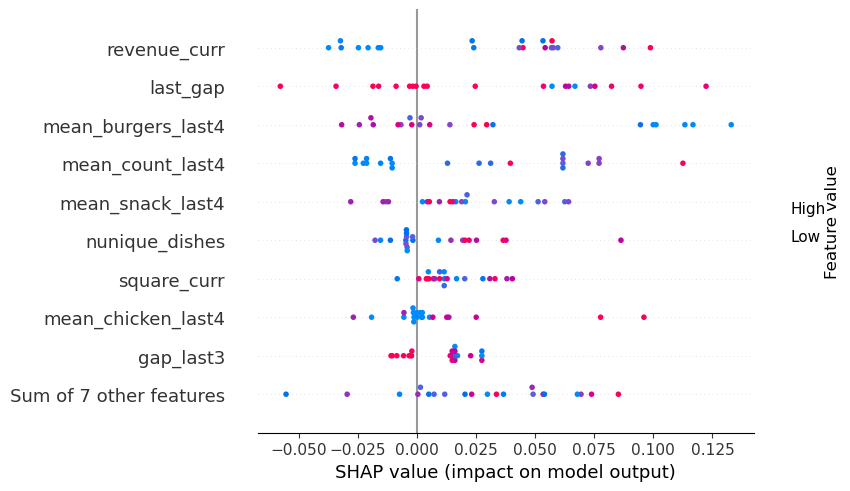

In [79]:
shap.plots.beeswarm(shap_values)

### Метрики

In [ ]:
for _df, _trg, nm in zip(
        [X_train, X_test, df_oot[cols]], 
        [y_train, y_test, df_oot[target_col]], 
        ['train', 'test', 'oot']):
    
    predict = cls.predict_proba(_df[cols])[:, 1]
    pred = cls.predict(_df[cols])
    auc = roc_auc_score(_trg, predict)
    f1_macro = f1_score(_trg, pred, average='macro')
    f1_weighted = f1_score(_trg, pred, average='weighted')

    print(f'AUC of {nm: <6}: {auc:.3f}')
    print(f'F1 macro of {nm: <6}: {f1_macro:.3f}')
    print(f'F1 weighted of {nm: <6}: {f1_weighted:.3f} \n')

## Test part

In [ ]:
df_test = pd.read_parquet('hackaton2023_test.gzip')

In [ ]:
df_test = make_features(df_test, False)

In [ ]:
df_check = df_test[
    ['customer_id', 'revenue', 'startdatetime', 'ownareaall_sqm', 'drinks',
     'burgers', 'snack', 'offer', 'chicken', 'bucket', 'dessert', 'pivo', 'sok', 'toilet', 'foodcourt', 'otdelno', 'count', 'dish_name']
].groupby(['customer_id', 'startdatetime']) \
    .agg({
    'revenue': 'sum',
    'ownareaall_sqm':'mean',
    'drinks':'sum',
    'burgers':'sum',
    'snack':'sum',
    'offer':'sum',
    'chicken':'sum',
    'bucket':'sum',
    'dessert':'sum',
    'pivo':'sum',
    'sok':'sum',
    'toilet':'max',
    'foodcourt':'max',
    'otdelno':'max',
    'count':'sum',
    'dish_name': list
}).reset_index()

In [ ]:
df_check.shape

In [ ]:
df_sample = df_check.sort_values(by=['customer_id', 'startdatetime']).reset_index()
df_sample['order_id'] = df_sample['customer_id'].astype(str) + '_' + df_sample['startdatetime'].astype(str)

out_arr = []
cols = ['customer_id', 'startdatetime', 'revenue', 'ownareaall_sqm', 'drinks',
        'burgers', 'snack', 'offer', 'chicken', 'bucket', 'count', 'order_id', 'dish_name']

for index, row in tqdm(df_sample[cols].iterrows()):
    res = reducer.push_line(row)
    if res is not None:
        # print('\t      '.join([str(x) for x in res]))
        out_arr.append(res)

res = reducer.print_result()
if res is not None:
    # print('\t'.join([str(x) for x in res]))
    out_arr.append(res)

In [ ]:
df_test_new = pd.DataFrame(out_arr, columns=[
    'customer_id', 'order_id',
    'mean_revenue_last4', 'mean_revenue_last3', 'mean_revenue_last2', 'rat_revenue',
    'mean_squares_last4', 'mean_squares_last3', 'mean_squares_last2',
    'mean_drinks_last4', 'mean_drinks_last3', 'mean_drinks_last2', 'rat_drinks',
    'mean_burgers_last4', 'mean_burgers_last3', 'mean_burgers_last2', 'rat_burgers',
    'mean_snack_last4', 'mean_snack_last3', 'mean_snack_last2', 'rat_snack',
    'mean_offer_last4', 'mean_offer_last3', 'mean_offer_last2', 'rat_offer',
    'mean_chicken_last4', 'mean_chicken_last3', 'mean_chicken_last2', 'rat_chicken',
    'mean_bucket_last4', 'mean_bucket_last3', 'mean_bucket_last2', 'rat_bucket',
    'mean_count_last4', 'mean_count_last3', 'mean_count_last2', 'rat_count',
    'gap_last3', 'last_gap',
    'mc1_dish', 'mc2_dish',
    
    'nunique_dishes', 'cat_hour', 'cat_gr_hour', 'cat_weekday', 'cat_gr_weekday',
    
    'revenue_curr', 'square_curr', 'drinks_curr', 'burgers_curr', 'snack_curr', 'offer_curr', 
    'chicken_curr', 'bucket_curr',     
    'cnt'
])

In [ ]:
cols = [
    'mean_revenue_last4', 'mean_revenue_last3', 'mean_revenue_last2', 'rat_revenue',
    'mean_squares_last4', 'mean_squares_last3', 'mean_squares_last2',
    'mean_drinks_last4', 'mean_drinks_last3', 'mean_drinks_last2', 'rat_drinks',
    'mean_burgers_last4', 'mean_burgers_last3', 'mean_burgers_last2', 'rat_burgers',
    'mean_snack_last4', 'mean_snack_last3', 'mean_snack_last2', 'rat_snack',
    'mean_offer_last4', 'mean_offer_last3', 'mean_offer_last2', 'rat_offer',
    'mean_chicken_last4', 'mean_chicken_last3', 'mean_chicken_last2', 'rat_chicken',
    'mean_bucket_last4', 'mean_bucket_last3', 'mean_bucket_last2', 'rat_bucket',
    'mean_count_last4', 'mean_count_last3', 'mean_count_last2', 'rat_count',
    'gap_last3', 'last_gap',
    'mc1_dish', 'mc2_dish',
    
    'nunique_dishes', 'cat_hour', 'cat_gr_hour', 'cat_weekday', 'cat_gr_weekday',
    
    'revenue_curr', 'square_curr', 'drinks_curr', 'burgers_curr', 'snack_curr', 'offer_curr', 
    'chicken_curr', 'bucket_curr',  
]

In [ ]:
df_test_smpl = df_test_new.sort_values(by='order_id', ascending=False).drop_duplicates(subset=['customer_id'], keep='first')

In [ ]:
df_test_smpl.shape

In [ ]:
df_test_smpl['mc1_dish'] = df_test_smpl['mc1_dish'].fillna('-1')
df_test_smpl['mc2_dish'] = df_test_smpl['mc2_dish'].fillna('-1')

In [ ]:
df_test_smpl['buy_post'] = cls.predict_proba(df_test_smpl[cols])[:, 1]

df_test_smpl['buy_post'] = df_test_smpl['buy_post'].apply(lambda x: 1 if x > 0.5 else 0) 
df_test_smpl['buy_post'].value_counts()

In [ ]:
df_out = pd.read_csv('submission.csv', sep=';')[['customer_id', 'date_diff_post']].merge(
    df_test_smpl[['customer_id', 'buy_post']]
)

In [ ]:
df_out.to_csv('submission_ex12.csv', sep=';', header=True, index=False)

In [ ]:
import pickle
with open(f'models/cls_064_top_{len(cols)}_feats.pkl', 'wb') as f:
    pickle.dump(cls, f)